In [1]:
# Import of the data 
# This can take a while 

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Window

DAU_SCHEMA = T.StructType([
    T.StructField('userId', T.StringType()),
    T.StructField('createdAt', T.StringType()),
    T.StructField('element', T.StringType()),
    T.StructField('view', T.StringType()),
    T.StructField(
        'data', T.StructType([
            T.StructField('score', T.LongType()),
            T.StructField('activity-title', T.StringType()),
        ]),
    ),
])

PATH = "s3a://alpha-health-pro/red/evermind/events/2020/*/*/*/*"
evermindDF_raw = spark.read.schema(schema=DAU_SCHEMA).json(PATH)
evermindDF_raw.count()

526896

In [2]:
df = evermindDF_raw\
    .withColumn("date", F.date_format(F.to_timestamp(F.col("createdAt")), "yyyy-MM-dd"))\
    .toPandas()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df.dropna(subset = ['data'], inplace=True)

In [4]:
df 

,userId,createdAt,element,view,data,date
0,7be8c72c-64c8-49ca-bfab-c1b16052c959,2020-04-30T08:01:57.027829+01:00,write-feedback,add_record_activity,"(None, Keeping a thought record)",2020-04-30
1,3506c23b-da1c-417e-af8c-9e3977aa08b7,2020-04-30T08:02:07.396241+01:00,programme_card,library,"(None, None)",2020-04-30
2,3506c23b-da1c-417e-af8c-9e3977aa08b7,2020-04-30T08:02:07.399540+01:00,None,programme_detail,"(None, None)",2020-04-30
3,3506c23b-da1c-417e-af8c-9e3977aa08b7,2020-04-30T08:02:07.421174+01:00,new,programme_detail,"(None, None)",2020-04-30
4,b9f3c379-7a53-440c-bbfa-3e63610989be,2020-04-30T08:02:07.090962+01:00,write-answer,question_record_activity,"(None, Escape your repetitive thoughts)",2020-04-30
...,...,...,...,...,...,...
526833,788b34ee-1e56-42c1-bdec-c55185a1ff71,2020-03-27T15:28:01.886931+01:00,None,home,"(None, None)",2020-03-27
526834,788b34ee-1e56-42c1-bdec-c55185a1ff71,2020-04-01T10:11:54.295003+02:00,None,home,"(None, None)",2020-04-01
526837,700cb20d-3c53-48eb-a0ae-6f57ee1fb11f,2020-04-16T16:10:07.838807-04:00,None,home,"(None, None)",2020-04-16
526838,5fd39651-a617-4c03-b26a-bcef8a936b71,2020-04-18T21:02:54.724417-04:00,None,home,"(None, None)",2020-04-19


In [5]:
import pandas as pd
def get_data(x):
    return x[0], x[1]

df[['score','activity']] = df['data'].apply(lambda x: pd.Series(get_data(x)))
df['score'] = pd.to_numeric(df['score'])

In [6]:
df['element'].unique()

array(['write-feedback', 'programme_card', None, 'new', 'write-answer',
       'input-done', 'next', 'done', 'good', 'activity_shape',
       'start_activity', 'start_programme', 'confirm_switch_button',
       'active', 'write-record', 'record_card', 'finish_questions',
       'step', 'finish', 'bad', 'completed', 'repeat_programme', 'close',
       'back', 'info', 'keep_reading', 'see_programme_overview',
       'modules_tab', 'programmes_tab', 'module_card', 'slide',
       'activity', 'dialog_close', 'input-cancel', 'paused',
       'resume_programme', 'audio', 'start_assessment',
       'explore_programmes', 'end_feedback_good', 'read-more', 'example',
       'locked_activity', 'answer', 'game_start', 'level_start',
       'target_sequence', 'initial_video', 'tile_correct',
       'user_sequence', 'level_end', 'continue', 'tile_error',
       'see_all_programmes', 'activities_tab', 'game_over',
       'done_for_now', 'same', 'notifications_tray', 'notifications_yes',
       'worse

In [7]:
df['activity'].unique()

array(['Keeping a thought record', None,
       'Escape your repetitive thoughts', 'My strengths',
       'Spotting your repetitive thinking', 'Starfall',
       'Midnight in the dunes', 'When events are beyond your control',
       'Dominating doubt and uncertainty', 'Being fair to yourself',
       'Social distancing and dealing with loneliness',
       'What are your unhelpful thoughts?', 'Deep belly breathing',
       'Sunset dream', 'What makes you feel bad about you?',
       'Positive thinking—gratitude', 'Waves', 'Label my strengths',
       "Beginner's progressive muscle relaxation", 'Expansion', nan,
       'Unguided deep belly breathing (3 min)',
       'Loving kindness meditation', 'Thunderstorm',
       'Unguided deep belly breathing', 'Switching your mind off for bed',
       'Review my strengths', 'Unguided deep belly breathing (5 min)',
       'Recognising unhelpful thoughts', 'Epoch',
       'Relax your body and mind for sleep - beginner',
       'Reflect on your trigg

In [139]:
#Categorise the activities in relax or thoughts
def get_activity_category(x):
    relax = ['Deep belly breathing', "Beginner's progressive muscle relaxation", 
        'Unguided deep belly breathing (5 min)', 'Progressive muscle relaxation', 
        'Unguided deep belly breathing (3 min)', 'Unguided deep belly breathing',
        'Loving kindness meditation', 'Controlling anger through mindfulness']
    pos_thoughts = ['Positive thinking - gratitude', 'Positive thinking - people',
       'Positive thinking - achievements']
    thoughts = ['Keeping a thought record', 'Spotting your repetitive thinking', 
        'Recognising unhelpful thoughts', 'Recognising unhelpful thoughts', 
        'Escape your repetitive thoughts']
    confidence = ['Being fair to yourself', 'What makes you feel bad about you?', 
        'Reflect on your triggers', 'Automatic thoughts and self-confidence', 
        'What are your automatic thoughts?', 'Examining our thoughts', 'Creating balanced thoughts'
        'Balance your thoughts', 'Balancing thoughts', 'To take with me', 'My strengths', 'Label my strengths'
        'Review my strengths']
    if x in pos_thoughts:
        return 1
    elif x in thoughts:
        return 2
    elif x in relax:
        return 3
    elif x in confidence:
        return 4
    else:
        return float('NaN')

df['cat'] = df['activity'].apply(lambda x: get_activity_category(x))

In [140]:
df['cat'].unique()

array([ 2., nan,  4.,  3.,  1.])

In [141]:
df2 = df.groupby(['userId','date'])
df2 = df2['score', 'cat', 'element'].agg(list)
df2.head()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


score  \
userId date                                                            
       2020-01-12                                         [nan, nan]   
       2020-02-05  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
       2020-02-06                [nan, nan, nan, nan, nan, nan, nan]   
       2020-02-08                                         [nan, nan]   
       2020-02-10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                                 cat  \
userId date                                                            
       2020-01-12                                         [nan, nan]   
       2020-02-05  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
       2020-02-06                [nan, nan, nan, nan, nan, nan, nan]   
       2020-02-08                                         [nan, nan]   
       2020-02-10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                             element  
userId date                                                           
       2020-01-12                                       [None, None]  
       2020-02-05  [None, None, None, None, None, None, None, Non...  
       2020-02-06         [None, None, None, None, None, None, None]  
       2020-02-08                                       [None, None]  
       2020-02-10  [None, None, None, None, None, None, None, Non...

In [142]:
def get_score_days(x):
    for ele in x: 
        if 0 < ele <= 12:
            return 0, 1
        elif 12 < ele <= 27:
            return 1, 1
        elif ele > 27:
            return 2, 1

df2[['scores', 'score_day']] = df2['score'].apply(lambda x: pd.Series(get_score_days(x)))

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [143]:
df2.dropna(subset = ['score_day'], inplace=True)

In [144]:
def get_raw_score(x):
    for ele in x: 
        if ele > 0:
            return ele

df2['raw_scores'] = df2['score'].apply(lambda x: get_raw_score(x))

In [145]:
df2

score  \
userId                               date                                                            
                                     2020-04-08  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-13  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-28  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
000d4f52-13dc-4600-9b02-3527dd646bc5 2020-04-16  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                                                            ...   
ffa2107e-f6d4-4f94-ac3b-7fecb3f2e390 2020-03-20  [nan, nan, nan, nan, 21.0, nan, 21.0, nan, nan...   
ffda0c59-732f-4ffd-997f-c10717a19829 2020-03-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
ffe605e7-b063-4ea1-9043-f9cb1c95269c 2020-04-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
fff7a670-3da9-4d23-a5ea-bb1cb657294b 2020-04-06  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
fffe0291-493a-4500-b3af-6fc6a8df1e9f 2020-04-13  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                                                               cat  \
userId                               date                                                            
                                     2020-04-08  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-13  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
                                     2020-04-28  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
000d4f52-13dc-4600-9b02-3527dd646bc5 2020-04-16  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
...                                                                                            ...   
ffa2107e-f6d4-4f94-ac3b-7fecb3f2e390 2020-03-20  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
ffda0c59-732f-4ffd-997f-c10717a19829 2020-03-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
ffe605e7-b063-4ea1-9043-f9cb1c95269c 2020-04-23  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
fff7a670-3da9-4d23-a5ea-bb1cb657294b 2020-04-06  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
fffe0291-493a-4500-b3af-6fc6a8df1e9f 2020-04-13  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                                                           element  \
userId                               date                                                            
                                     2020-04-08  [None, None, None, None, None, None, None, Non...   
                                     2020-04-13  [None, None, None, None, None, None, None, Non...   
                                     2020-04-23  [None, None, None, None, None, None, None, Non...   
                                     2020-04-28  [None, None, None, None, None, None, None, Non...   
000d4f52-13dc-4600-9b02-3527dd646bc5 2020-04-16  [None, start_assessment, None, None, None, Non...   
...                                                                                            ...   
ffa2107e-f6d4-4f94-ac3b-7fecb3f2e390 2020-03-20  [None, None, None, None, None, None, None, Non...   
ffda0c59-732f-4ffd-997f-c10717a19829 2020-03-23  [None, start_assessment, None, None, None, Non...   
ffe605e7-b063-4ea1-9043-f9cb1c95269c 2020-04-23  [continue, None, None, None, activity_shape, a...   
fff7a670-3da9-4d23-a5ea-bb1cb657294b 2020-04-06  [None, start_assessment, None, None, None, Non...   
fffe0291-493a-4500-b3af-6fc6a8df1e9f 2020-04-13  [None, start_assessment, None, None, None, Non...   

                                                 scores  score_day  raw_scores  
userId                         

In [146]:
def get_ratings(element, cat, scores, raw_scores):
    total = []
    
    for i, e in enumerate (element): 
        ratings = []
        #print(e)
        #break
        if e == 'good':
            #print(e)
            if cat[i]> 0:
                ratings.append(scores)
                ratings.append(cat[i])
                ratings.append(1) 
                ratings.append(raw_scores)
                total.append(ratings)
        elif e == 'bad':
            if cat[i]> 0:
                ratings.append(scores)
                ratings.append(cat[i])
                ratings.append(0)   
                ratings.append(raw_scores)
                total.append(ratings)
    print(total)
    return total

ratings = df2.apply(lambda x: get_ratings(x['element'], x['cat'], x['scores'], x['raw_scores']), axis = 1)

[]
[[0.0, 1.0, 1, 7.0]]
[]
[[0.0, 4.0, 1, 5.0], [0.0, 1.0, 1, 5.0], [0.0, 2.0, 1, 5.0], [0.0, 1.0, 1, 5.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 4.0, 0, 16.0], [1.0, 4.0, 0, 16.0], [1.0, 4.0, 0, 16.0]]
[]
[]
[]
[]
[[1.0, 1.0, 1, 15.0]]
[]
[]
[]
[]
[]
[[0.0, 3.0, 1, 8.0]]
[]
[]
[]
[[0.0, 2.0, 1, 9.0], [0.0, 2.0, 0, 9.0]]
[[1.0, 2.0, 1, 23.0]]
[]
[[1.0, 2.0, 0, 18.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 4.0, 1, 19.0], [1.0, 4.0, 1, 19.0], [1.0, 4.0, 1, 19.0]]
[[1.0, 4.0, 1, 15.0]]
[]
[]
[[1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 2.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0]]
[[1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 4.0, 1, 27.0], [1.0, 1.0, 1, 27.0], [1.0, 1.0, 1, 27.0], [1.0, 1.0, 1, 27.0]]
[]
[]
[]
[[0.0, 2.0, 1, 2.0]]
[]
[]
[]
[[1.0, 2.0, 1, 16.0]]
[]
[]
[]
[]
[[1.0, 4.0,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 25.0], [1.0, 2.0, 1, 25.0]]
[]
[]
[]
[[1.0, 2.0, 1, 25.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[2.0, 4.0, 1, 30.0], [2.0, 4.0, 1, 30.0]]
[]
[]
[]
[]
[[1.0, 2.0, 0, 25.0]]
[]
[]
[]
[[1.0, 2.0, 1, 21.0], [1.0, 2.0, 1, 21.0], [1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 22.0]]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 22.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 0, 14.0], [1.0, 1.0, 1, 14.0], [1.0, 1.0, 1, 14.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 21.0]]
[[2.0, 2.0, 1, 28.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[2.0, 2.0, 0, 35.0]]
[]
[]
[]
[[1.0, 2.0, 1, 24.0], [1.0, 2.0, 1, 24.0], [1.0, 2.0, 1, 24.0]]
[]
[]
[]
[[1.0, 1.0, 1, 23.0], [1.0, 1.0, 1, 23.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 23.0]]
[]
[]
[[1.0, 2.0, 1, 24.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[[2.0, 2.0, 0, 28.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 19.0]]
[]
[]
[]
[[0.0, 4.0, 1, 12.0], [0.0, 2.0, 1, 12.0], [0.0, 2.0, 1, 12.0], [0.0, 4.0, 1, 12.0]]
[]
[]
[]
[[1.0, 4.0, 1, 21.0], [1.0, 4.0, 1, 21.0]]
[]
[]
[]
[]
[[1.0, 4.0, 0, 27.0]]
[]
[]
[[1.0, 2.0, 1, 20.0]]
[]
[]
[[1.0, 2.0, 1, 16.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 2.0, 1, 21.0], [1.0, 2.0, 1, 21.0], [1.0, 2.0, 1, 21.0], [1.0, 3.0, 1, 21.0]]
[]
[]
[]
[]
[]
[]
[[2.0, 2.0, 1, 34.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[2.0, 2.0, 1, 36.0]]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[[1.0, 1.0, 1, 21.0], [1.0, 1.0, 1, 21.0]]
[]
[]
[]
[]
[]
[]
[[2.0, 2.0, 0, 30.0]]
[]
[]


In [147]:
ratings

userId                                date      
                                      2020-04-08                                                   []
                                      2020-04-13                                 [[0.0, 1.0, 1, 7.0]]
                                      2020-04-23                                                   []
                                      2020-04-28    [[0.0, 4.0, 1, 5.0], [0.0, 1.0, 1, 5.0], [0.0,...
000d4f52-13dc-4600-9b02-3527dd646bc5  2020-04-16                                                   []
                                                                          ...                        
ffa2107e-f6d4-4f94-ac3b-7fecb3f2e390  2020-03-20                                                   []
ffda0c59-732f-4ffd-997f-c10717a19829  2020-03-23                                                   []
ffe605e7-b063-4ea1-9043-f9cb1c95269c  2020-04-23                                [[2.0, 2.0, 0, 30.0]]
fff7a670-3da9-4d23-a5ea-bb1cb6572

In [148]:
flat_list = []
for sublist in ratings:
    for item in sublist:
        flat_list.append(item)

In [149]:
df_results = pd.DataFrame(data=flat_list, columns=["PSS", "activity", "rating", 'raw_PSS'])

## Hypothesis testing

H1: Positive thought journaling will be better at reducing stress than mindfulness in negative (stress) condition

H2: Mindfulness will be equally as effective as positive thought journaling in relaxed condition since the focus on the current thoughts should naturally be positive after relaxed mood induction making both interventions more similar


### Working With Thoughts

In [130]:
from scipy import stats
#Significant difference between low and high stress for thought journaling
low = df_results[(df_results['PSS']==0) & (df_results['activity']==2)]['rating']
high = df_results[(df_results['PSS']==2) & (df_results['activity']==2)]['rating']
stats.ttest_ind(low, high)

Ttest_indResult(statistic=2.6367653755254032, pvalue=0.010097084460151052)

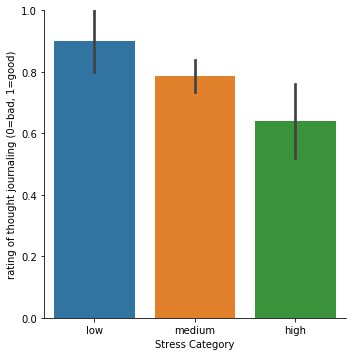

In [133]:
import seaborn as sns
fig = sns.catplot(x="PSS", y= 'rating', kind="bar", data =df_results[df_results['activity']==2])
fig.set_axis_labels('Stress Category', 'rating of thought journaling (0=bad, 1=good)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(0,1))

### Positive Thoughts

In [158]:
#Significant difference between moderate and high stress for positive thoughts
moderate = df_results[(df_results['PSS']==1) & (df_results['activity']==1)]['rating']
high = df_results[(df_results['PSS']==2) & (df_results['activity']==1)]['rating']
stats.ttest_ind(moderate, high)

Ttest_indResult(statistic=2.8401044054992415, pvalue=0.005342485674648233)

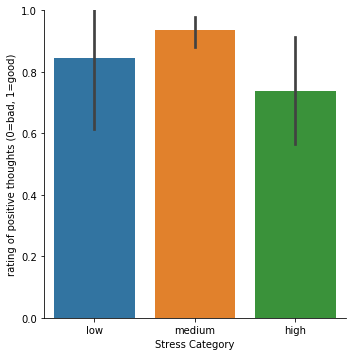

In [135]:
fig = sns.catplot(x="PSS", y= 'rating', kind="bar", data =df_results[df_results['activity']==1])
fig.set_axis_labels('Stress Category', 'rating of positive thoughts (0=bad, 1=good)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(0,1))

### Relaxation

In [119]:
#No significant differences for relaxation 
low = df_results[(df_results['PSS']==0) & (df_results['activity']==3)]['rating']
high = df_results[(df_results['PSS']==2) & (df_results['activity']==3)]['rating']
stats.ttest_ind(low, high)

Ttest_indResult(statistic=-1.1710800875382403, pvalue=0.2642960660107213)

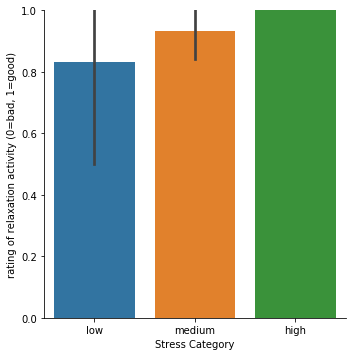

In [136]:
fig = sns.catplot(x="PSS", y= 'rating', kind="bar", data =df_results[df_results['activity']==3])
fig.set_axis_labels('Stress Category', 'rating of relaxation activity (0=bad, 1=good)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(0,1))

### Self-Confidence

In [153]:
#No significant differences for relaxation 
low = df_results[(df_results['PSS']==0) & (df_results['activity']==4)]['rating']
high = df_results[(df_results['PSS']==2) & (df_results['activity']==4)]['rating']
stats.ttest_ind(low, high)

Ttest_indResult(statistic=0.9607689228305232, pvalue=0.34624875048594284)

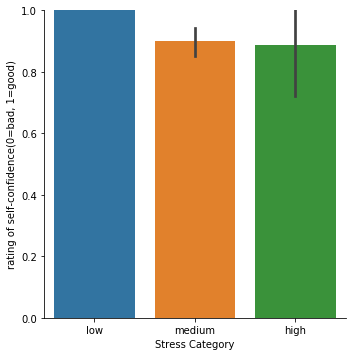

In [154]:
import seaborn as sns
fig = sns.catplot(x="PSS", y= 'rating', kind="bar", data =df_results[df_results['activity']==4])
fig.set_axis_labels('Stress Category', 'rating of self-confidence(0=bad, 1=good)')
fig.set_xticklabels(["low", "medium", "high"])
fig.set(ylim=(0,1))

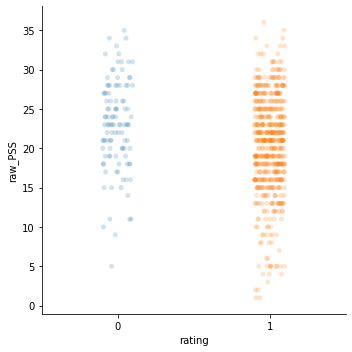

In [156]:
sns.catplot(x="rating", y="raw_PSS", data=df_results, alpha = 0.2);

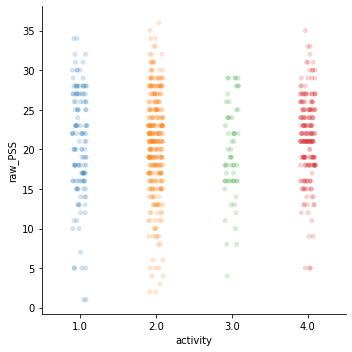

In [157]:
sns.catplot(x="activity", y="raw_PSS", data=df_results, alpha = 0.2);